# Libraries

In [1]:
import gc
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init
from pprint import pprint

# 🚫 Suppressing warnings 🚫
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

In [3]:
from scipy.stats import entropy
from collections import Counter
import polars as pl

In [4]:
from joblib import Parallel, delayed
from time import sleep, time
from multiprocessing import cpu_count

# Reading train_series parquet

In [5]:
%%time
# inspired by https://www.kaggle.com/code/enricomanosperti/detect-sleep-states-first-preprocessing-and-eda
import polars as pl
train_series = (pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 1min 1s, sys: 15.4 s, total: 1min 16s
Wall time: 51.8 s


# Reading train_events - use to get the labels

In [6]:
%%time
train_events = (pl.scan_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 13.2 ms, sys: 7.85 ms, total: 21.1 ms
Wall time: 48.6 ms


# Reading test_series - use to get predictions and upload solution

In [7]:
%%time
test_series = (pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 4.47 ms, sys: 1.12 ms, total: 5.59 ms
Wall time: 8.06 ms


In [8]:
%%time
# inspired by https://www.kaggle.com/code/renatoreggiani/reduce-memory-usage-zzzs-cmi
# with tweaks determined by the selected polars loading strategy
# tweaks inspired by https://github.com/softhints/Pandas-Tutorials/blob/master/column/3.check-dtype-column-columns-pandas-dataframe.ipynb
from pandas.api.types import is_datetime64_ns_dtype
def reduce_mem_usage(df):
    """ iterate through all numeric columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not is_datetime64_ns_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float16)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')
    
    return df

train_series = reduce_mem_usage(train_series)

Memory usage of dataframe is 5368.84 MB
Memory usage after optimization is: 3904.61 MB
Decreased by 27.27%
CPU times: user 3.52 s, sys: 487 ms, total: 4 s
Wall time: 4.01 s


In [9]:
%%time
test_series = reduce_mem_usage(test_series)

Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.01 MB
Decreased by 31.61%
CPU times: user 6.2 ms, sys: 2.03 ms, total: 8.22 ms
Wall time: 7.87 ms


# remove series with missing labels - only train with the series with all labels

In [10]:
train_events.groupby(['series_id'])['step'].size()

series_id
038441c925bb     46
03d92c9f6f8a     74
0402a003dae9     48
04f547b8017d     74
05e1944c3818     16
               ... 
fa149c3c4bde     48
fb223ed2278c    106
fbf33b1a2c10     48
fcca183903b7     72
fe90110788d2     70
Name: step, Length: 277, dtype: int64

# Merge train series with train events to get the label

In [64]:
def get_series_data(series_id):
    
    df=train_series[(train_series['series_id']==series_id)][['series_id', 'step', 'timestamp', 'anglez', 'enmo', 'year', 'month',
       'day', 'hour']]
    df['date_time'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df = df.drop('timestamp', axis=1)
    
    ev=train_events[(train_events['series_id']==series_id)][['series_id','night','event','step','timestamp']]
    ev = ev[ev['step'].notna()]
    ev['date_time'] = pd.to_datetime(ev['timestamp']).apply(lambda t: t.tz_localize(None))
    ev = ev.drop('timestamp', axis=1)
    
    df2 = pd.merge(df, ev, on='date_time', how='outer')
    df2['step']=df2['step_x']
    df2['series_id']=df2['series_id_x']
    df2 = df2.drop(['series_id_x','series_id_y','step_x','step_y'], axis=1)
    df2['event'] = df2['event'].fillna(0)

    # fill values for night feature
    df2['night'][0] = 1
    df2['night'] = df2['night'].interpolate()
    df2['night'] = round(df2['night'])
    # map numeric values to event feature
    df2.loc[df2['event']=='onset','event'] = -1
    df2.loc[df2['event']=='wakeup','event'] = 1
    
    df2['year_month_day']=df2['year'].astype(str) + df2['month'].astype(str).str.zfill(2)+ df2['day'].astype(str).str.zfill(2)

    df3=df2.groupby('night').year_month_day.nunique().reset_index()
    #df3=df3[(df3['year_month_day']<3)]
   
    df4 = pd.merge(df2, df3, on='night', how='inner')
    
    df4 = df4.drop(['year_month_day_x','year_month_day_y'], axis=1)
    
    df5=df4.groupby(['night'])['event'].nunique().reset_index()
    df5=df5[(df5['event']==3)]
    df6 = pd.merge(df4, df5[['night']], on='night', how='inner')
    
    df6['day'] = df6['day'].apply(str)
    df6['month'] = df6['month'].apply(str)
    df6['year_month_day']=df6['year'].astype(str) + df6['month'].astype(str)+ df6['day'].astype(str)
    
    df7=df6.groupby(['year','month','day'])['event'].nunique().reset_index()
    df7['year_month_day']=df7['year'].astype(str) + df7['month'].astype(str)+ df7['day'].astype(str)
    df7=df7[(df7['event']>1)]
    df8 = pd.merge(df6, df7[['year_month_day']], on='year_month_day', how='inner')
    
    return df8

In [32]:
def visualize_nights_ts(series_id):
    series_data_df = get_series_data(series_id)
    
    for i in set(series_data_df['night']):
        
        df22 = series_data_df[series_data_df['night']==i]
        
        #print(df22)
        
        df22['anglez'] = df22['anglez'] / max(abs(max(df22['anglez'])),abs(min(df22['anglez'])))
        df22['enmo'] = df22['enmo'] / max(abs(max(df22['enmo'])),abs(min(df22['enmo'])))
        df22['event'] = df22['event'] / max(abs(max(df22['event'])),abs(min(df22['event'])),1e-10)
        
        if df22['event'].max() == 1:
            #display(Markdown('###  Control chart: ' + series_id + ', night ' + str(int(i)) ))
            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot()
            ax.plot(df22['date_time'], df22['anglez'], color='k', linewidth=0.5, label="anglez")
            ax.plot(df22['date_time'], df22['enmo'], color='b', linewidth=0.5, label="enmo")
            ax.plot(df22['date_time'], df22['event'], color='r', label="event")
            ax.legend()
            ax.set_title("".join(['Series Id : ', series_id, ' [Night# ', str(int(i)), ']']))
            ax.set_xlabel('DateTime')
            ax.set_ylabel('Normalized anglez, enmo, event [-]')
            ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
            ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S"))
            labels = ax.get_xticklabels()
            plt.setp(labels, rotation=40, fontsize=8)
            plt.show()

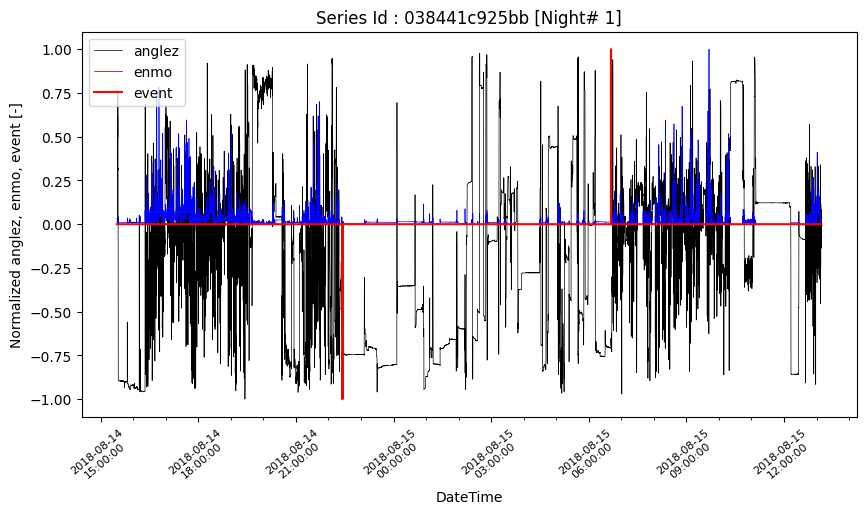

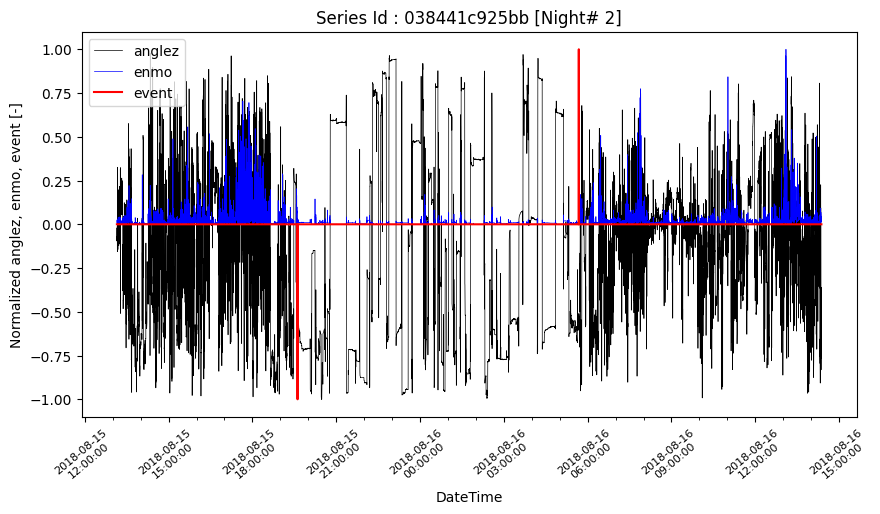

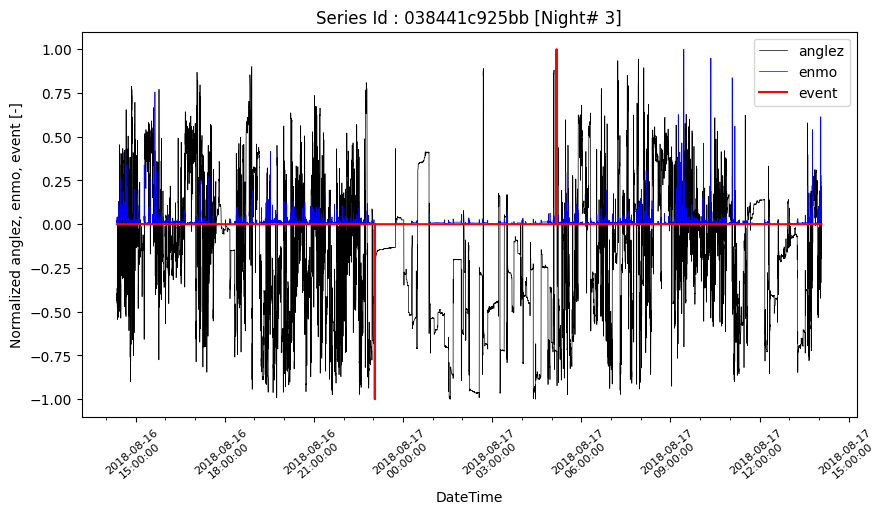

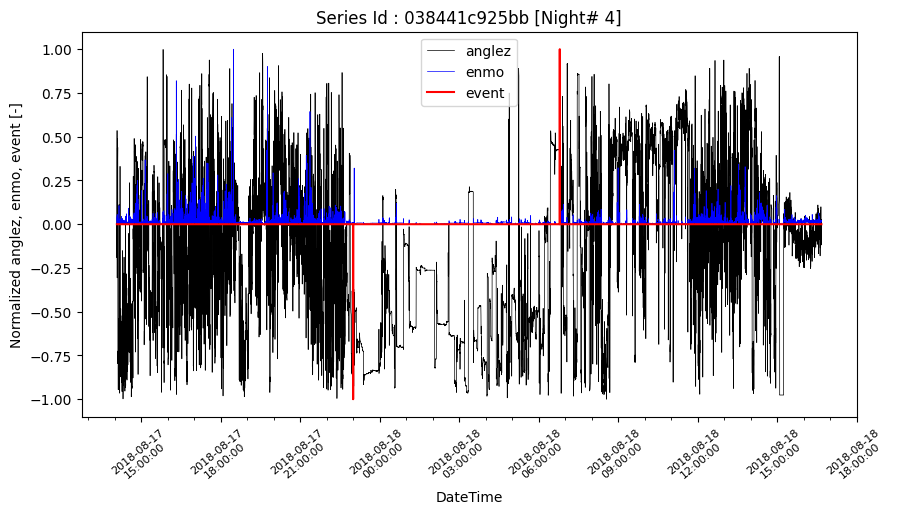

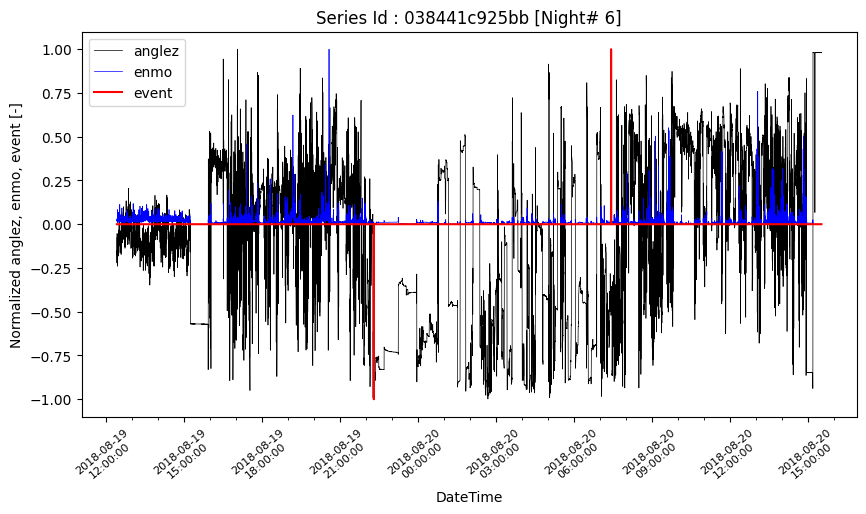

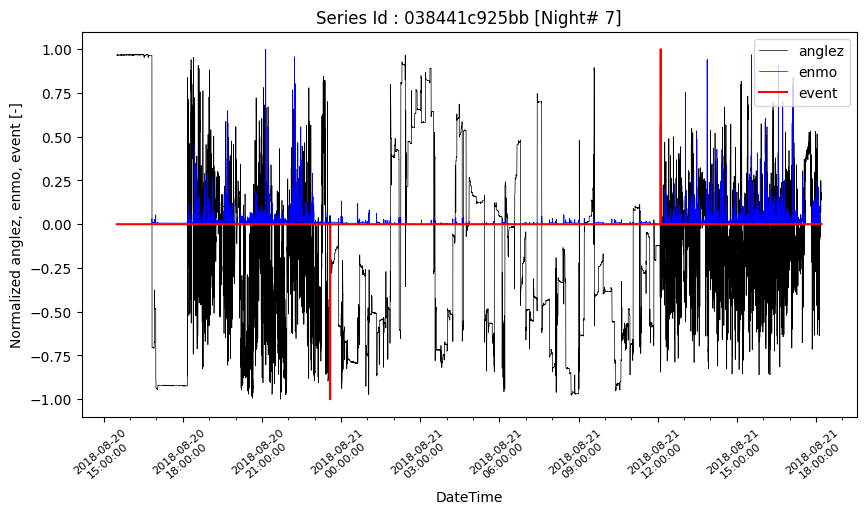

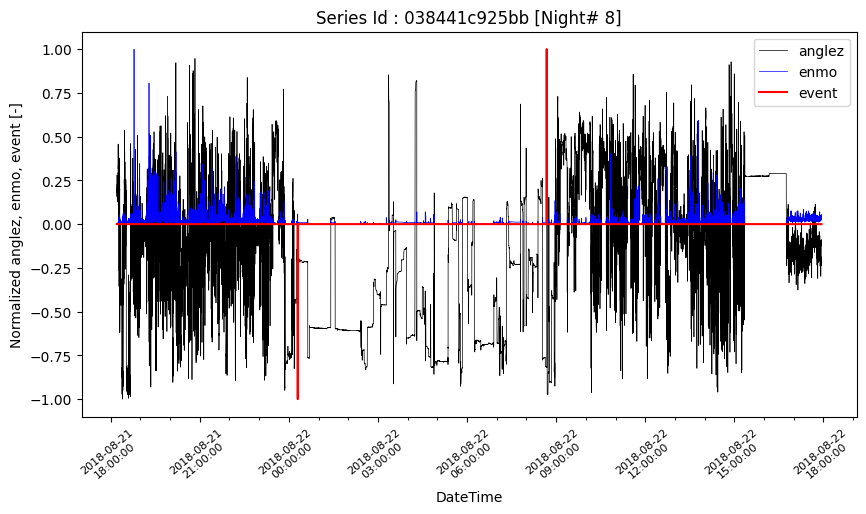

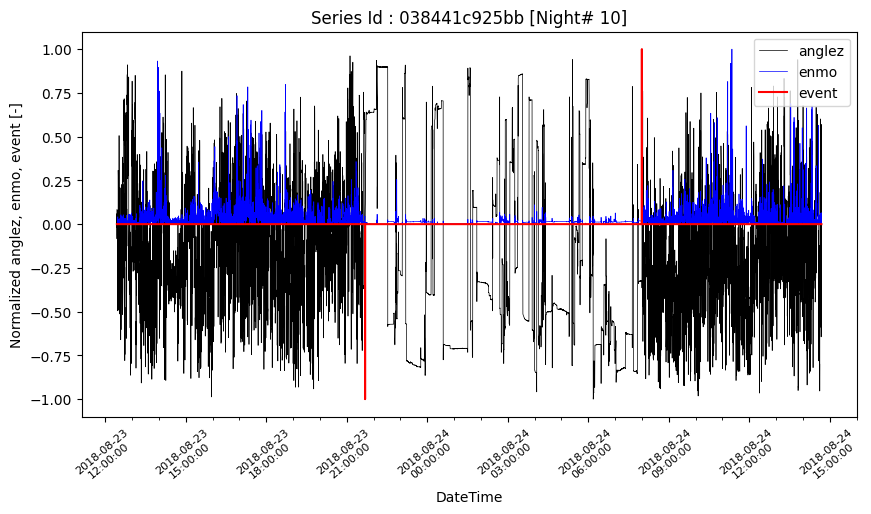

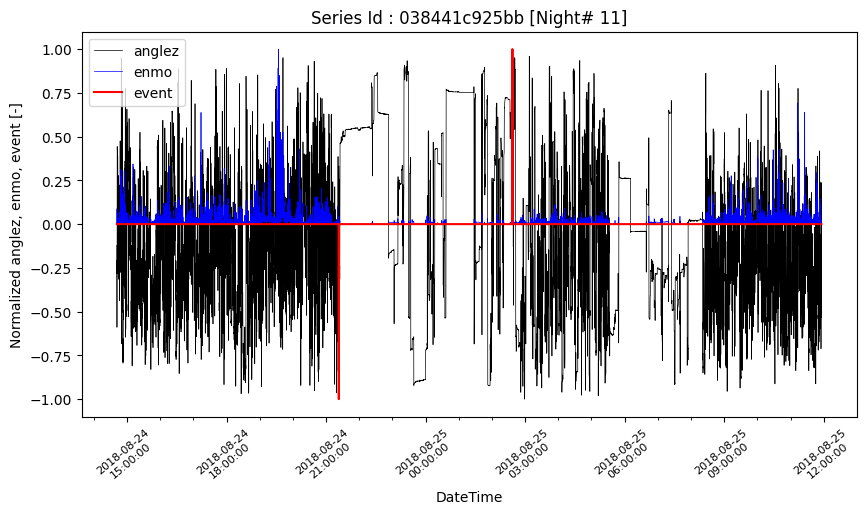

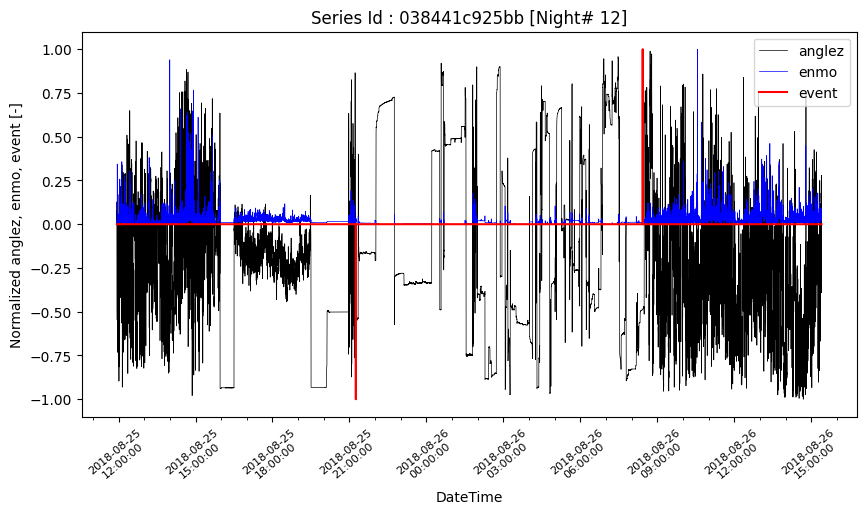

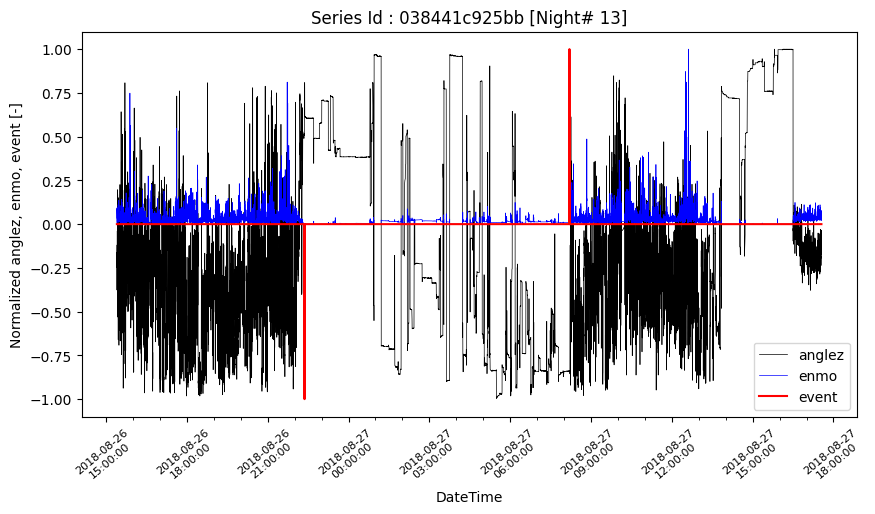

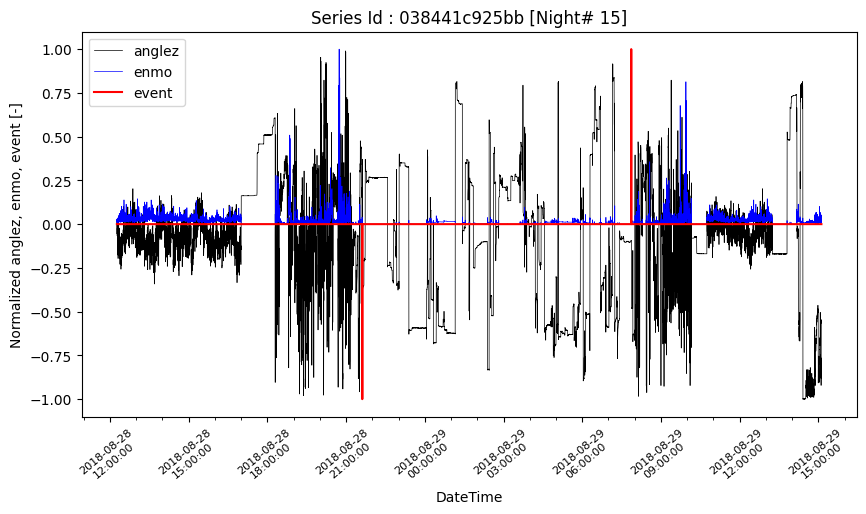

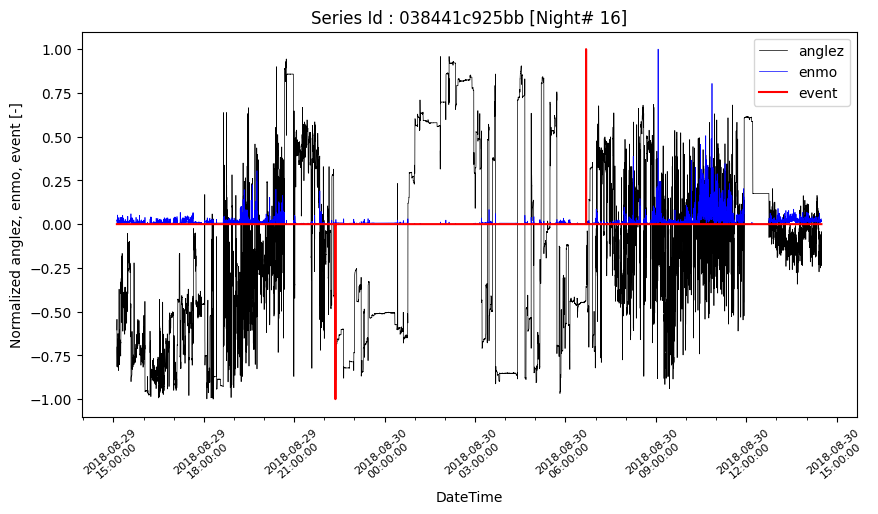

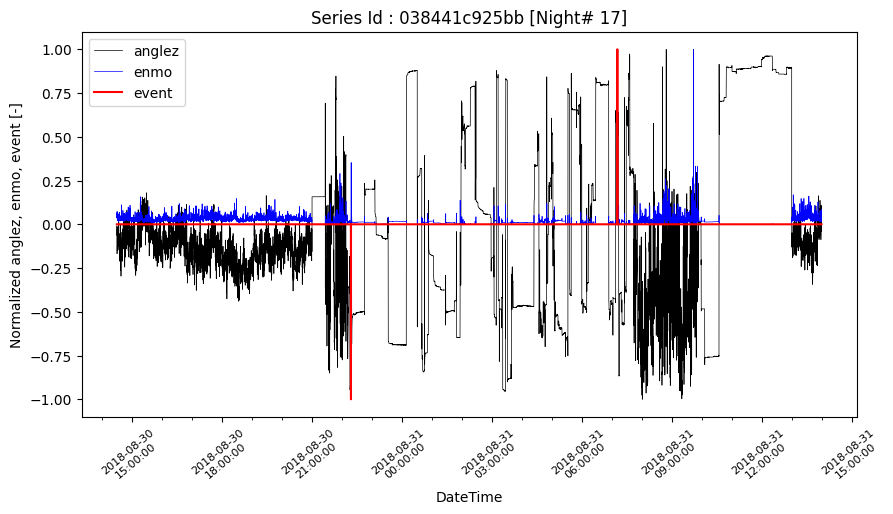

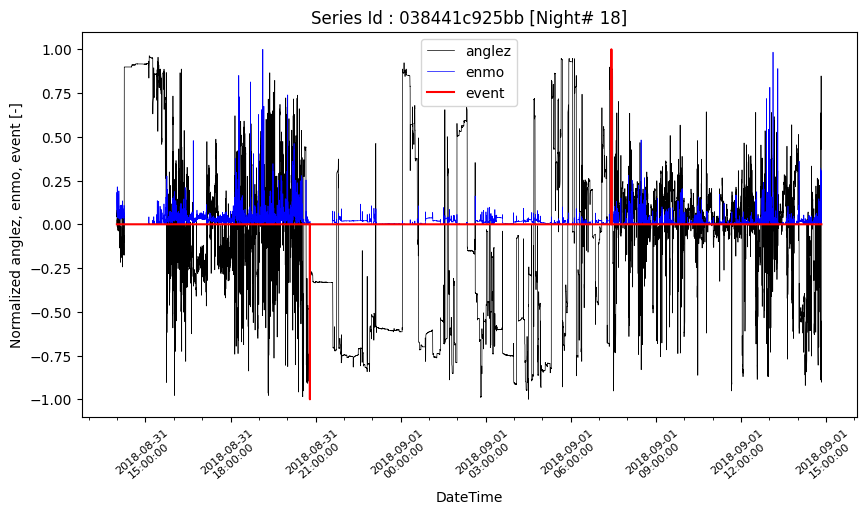

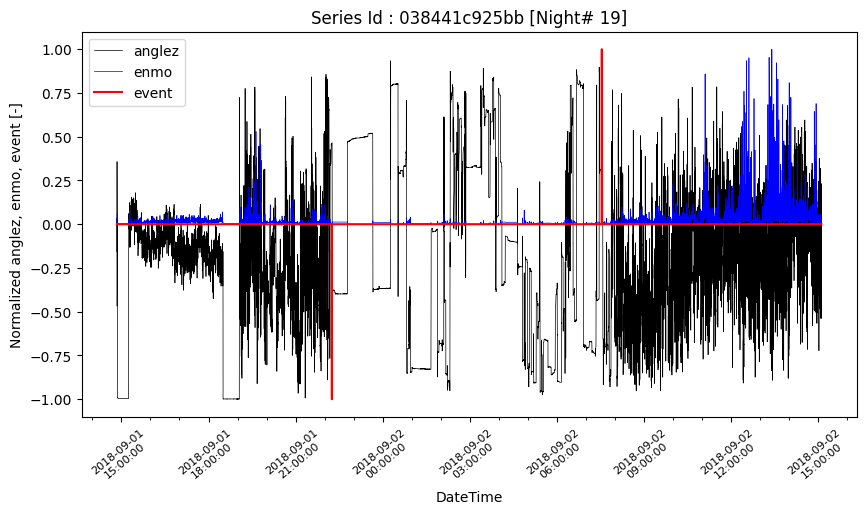

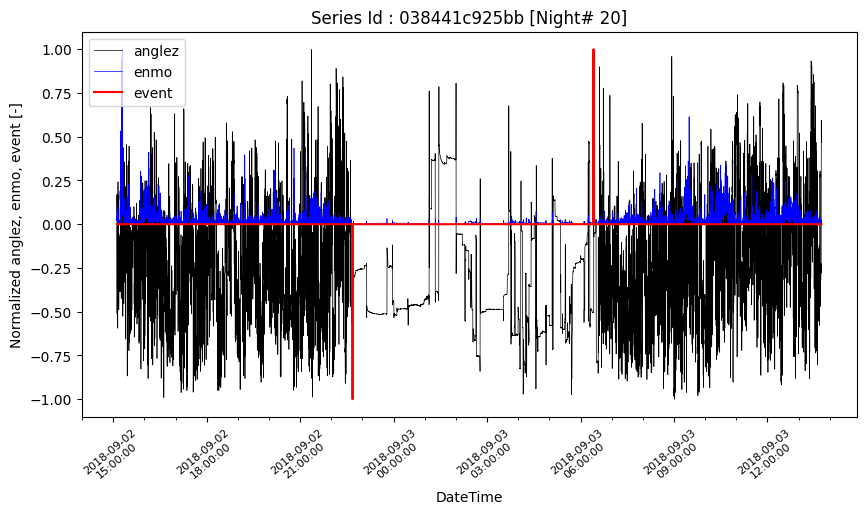

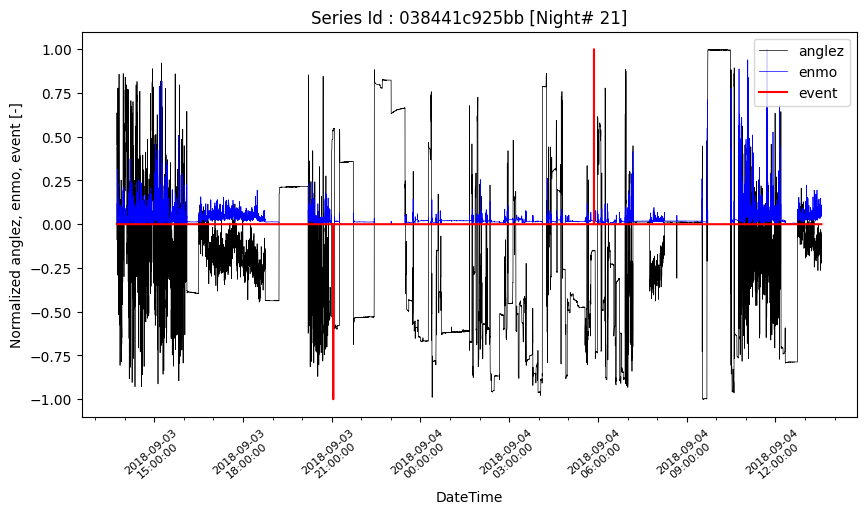

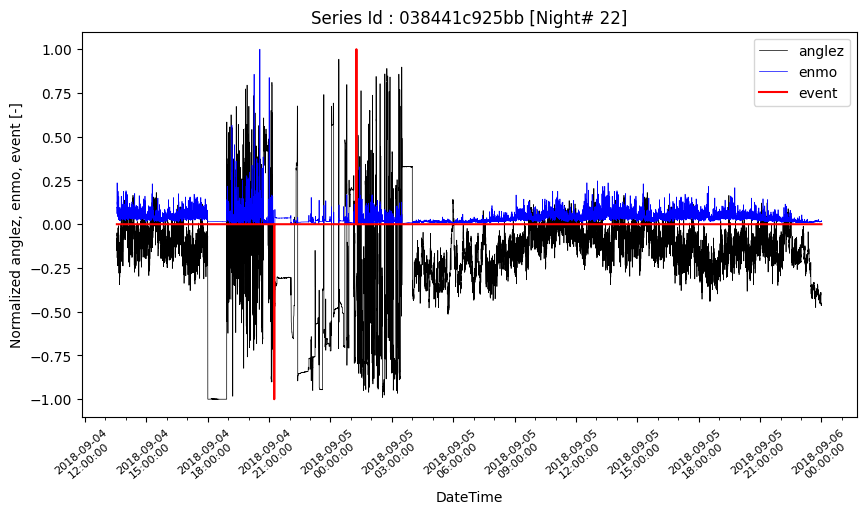

In [68]:
series_id = '038441c925bb'#'3d53bfea61d6' #0a96f4993bd7 # 038441c925bb
visualize_nights_ts(series_id)

In [67]:
train_events[(train_events['series_id']==series_id)]

,series_id,night,event,step,timestamp,year,month,day,hour
3558,3d53bfea61d6,1,onset,6972.0,2019-02-20 21:26:00,2019.0,2.0,20.0,21.0
3559,3d53bfea61d6,1,wakeup,13680.0,2019-02-21 06:45:00,2019.0,2.0,21.0,6.0
3560,3d53bfea61d6,2,onset,24828.0,2019-02-21 22:14:00,2019.0,2.0,21.0,22.0
3561,3d53bfea61d6,2,wakeup,30996.0,2019-02-22 06:48:00,2019.0,2.0,22.0,6.0
3562,3d53bfea61d6,3,onset,43776.0,2019-02-23 00:33:00,2019.0,2.0,23.0,0.0
3563,3d53bfea61d6,3,wakeup,48456.0,2019-02-23 07:03:00,2019.0,2.0,23.0,7.0
3564,3d53bfea61d6,4,onset,60996.0,2019-02-24 00:28:00,2019.0,2.0,24.0,0.0
3565,3d53bfea61d6,4,wakeup,65472.0,2019-02-24 06:41:00,2019.0,2.0,24.0,6.0
3566,3d53bfea61d6,5,onset,78924.0,2019-02-25 01:22:00,2019.0,2.0,25.0,1.0
3567,3d53bfea61d6,5,wakeup,83208.0,2019-02-25 07:19:00,2019.0,2.0,25.0,7.0
